# different by splitting to train test valid (here valid and test are switched)

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from dataset_loader import *
from utils import *
from datasets import Dataset, DatasetDict
from joblib import dump, load
import datasets
import logging
import warnings
from retrain_utils import *
logging.disable(logging.WARNING) 
datasets.set_progress_bar_enabled(False)
warnings.simplefilter("ignore")

SEED = 84
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [23]:
dataset_name = 'corona'
ds = get_ds(dataset_name)

In [24]:
test_valid = ds['val'].train_test_split(0.5, seed = 42)
ds = DatasetDict({
    'train': ds['train'],
    'val': test_valid['test'],
    'test': test_valid['train']})

In [6]:
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_name)
folder_name = 'svm'

In [27]:
retrain_utils = RetrainUtils(model_name, dataset_name, folder_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [28]:
ds['train'] = removed_train

In [29]:
model = MySVM()
model.train(ds, tokenizer)

Train accuracy 0.9411477649814561
Validation accuracy 0.7770588235294118


In [26]:
save_folder = f'svm/{dataset_name}/model_v2'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
dump(model, f'{save_folder}/traced.pt') 

['svm/corona/model_v2/traced.pt']

In [30]:
save_folder = f'svm/{dataset_name}/updated_model_v2'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
dump(model, f'{save_folder}/traced.pt') 

['svm/corona/updated_model_v2/traced.pt']

### saved best model's folder as 'updated_model_v2'

In [18]:
model = load(f'svm/{dataset_name}/updated_model_v2/traced.pt') 
orig_model = load(f'svm/{dataset_name}/model_v2/traced.pt') 
tokenizer = AutoTokenizer.from_pretrained(model_name)

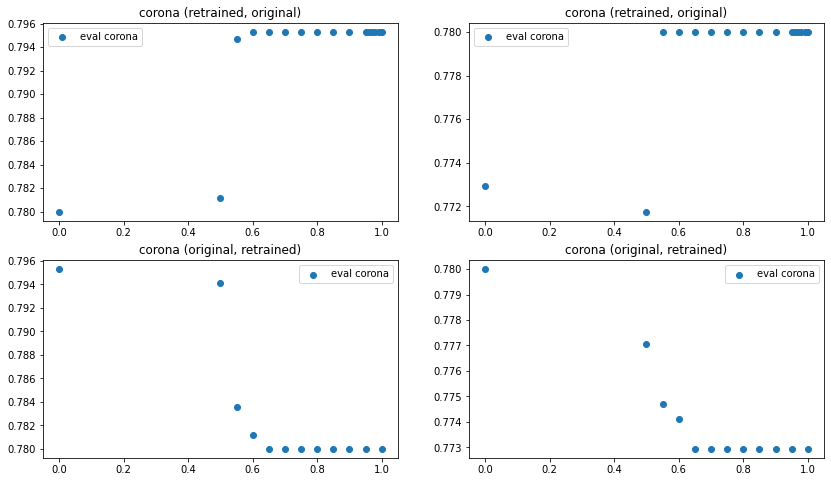

In [20]:
test_valid = get_ds('corona')['val'].train_test_split(0.5, seed = 42)
ensemble_results(folder_name, model_name, 'corona', 'corona', test_valid['test'], test_valid['train'], 'updated_model_v2/traced.pt', 'model_v2/traced.pt')

In [13]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i love movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i hate movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])